<a href="https://colab.research.google.com/github/ShruthiJaisimha/Part-1-Master-Thesis/blob/master/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

seed = 3
tf.set_random_seed(seed)
np.random.seed(seed)

system_stat = 'Normal'
#np.dtype(np.float32) 
#tf.enable_eager_execution
#tfe = tf.contrib.eager

###### creating input train

sequence_length = 1000
def input_train(x):
  max_rate = 0.5
  max_input = 1
  rate = (x/max_input)*max_rate
  if rate>=max_rate:
    y = 1
  else:
    y = 0
  return y 

def generate_data(B, H_, thr_, Ny, Nx, x_delta, thr_delta, sigma_delta, mode='IID'):
  x_true = np.zeros([B,Nx,1])
  #x_true = np.random.uniform(low = x_delta[0], high=x_delta[1], size=(,Nx,1))
  #x_true = np.random.normal(size=(,Nx,1))
  H = np.zeros([B,Ny,Nx])
  thr = np.zeros([B,Ny,1])
  noise = np.zeros([B,Ny])
  C = np.zeros([B,Ny,Ny])
  for i in range(B):
    x_true[i,:,:] = np.random.uniform(low = x_delta[0], high=x_delta[1], size=(Nx,1))
    H[i,:,:] = H_
    thr[i,:] = thr_
    if mode=='IID':
      sigma = np.random.uniform(low=sigma_delta[0], high=sigma_delta[1])
      #noise = sigma*np.random.randn(Ny,1)
      C[i,:,:] = (sigma**2)*np.eye(Ny)
      noise[i,:] = np.random.multivariate_normal(  np.zeros([Ny])  , C[i,:,:] )
    elif mode=='WNI':
      sigma = np.random.uniform(low=sigma_delta[0], high=sigma_delta[1], size=(Ny))
      C[i,:,:] = np.diag(sigma**2)
      noise[i,:] = np.random.multivariate_normal(  np.zeros([Ny])  , C [i,:,:])
  #noise[i,:] = np.reshape(noise, (Ny,1))
  y = np.squeeze(np.matmul(H,x_true),-1) + noise
  r = np.sign(y - np.squeeze(thr,-1))
  #r = r.reshape((Ny))
  return y, H, x_true, C, r, thr

##### Neural Layers



def weight_variable(shape):
  initial = tf.random_normal(shape, stddev=0.01)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.random_normal(shape, stddev=0.01)
  return tf.Variable(initial)


#####

Ny = 512
Nx = 1
B= 200
L= 10 # total number of layer

model_name= 'Ny'+str(Ny)+'Nx'+str(Nx)+'B'+str(B)+'L'+str(L)
#x_delta = [0, 3]
#thr_delta = [-20,20]
sigma_delta = [0.1, 0.5] #1
x_delta = [0.3, 0.3]
thr_delta = [0,0]
#sigma_delta = [0, 0] #1
mode='WNI'

H1 = np.random.randn(Ny,Nx)
thr1 = np.random.uniform(low = thr_delta[0], high = thr_delta[1], size=(Ny,1))
np.savetxt('H1'+model_name+'.csv', H1, delimiter=",")
np.savetxt('thr1'+model_name+'.csv', thr1, delimiter=",")

startingLearningRate = 0.0001
decay_factor = 0.97
decay_step_size = 1000
train_iter = 100
res_alpha=0.9

#####


#tf.reset_default_graph()
sess = tf.InteractiveSession()
#tf.summary.FileWriter('/content/DeepUnfolding/', sess.graph)

#### Loss and Learning Parameters
#batchSize = tf.placeholder(tf.int32)
org_signal = tf.placeholder(tf.float32, shape=[None,Nx,1], name='org_siganl')
r = tf.placeholder(tf.float32, shape=[None,Ny], name= 'one-bit-data')
C = tf.placeholder(tf.float32, shape = [None,Ny, Ny], name = 'noise-cov')
tau = tf.placeholder(tf.float32, shape=[None,Ny,1], name='Thresholds')
H = tf.placeholder(tf.float32, shape=[None,Ny,Nx], name='Sensing-Matrix')
delta = tf.Variable(1.)
#X1 = np.random.uniform(low = x_delta[0], high=x_delta[1], size=(Nx,1))
#### Forming the vectors and matrices used in the deep unfolding
Omega = tf.linalg.diag(r)
C_ = tf.linalg.inv(tf.sqrt(C))
Omega_tilde = tf.matmul(Omega,C_)
H_tilde = tf.matmul(Omega_tilde,H)
H_tilde_T = tf.transpose(H_tilde)
H_tilde_T = tf.transpose(H_tilde_T, perm=[2,0,1])
tau_tilde = tf.matmul(Omega_tilde, tau)
tau_tilde = tf.squeeze(tau_tilde,-1)
X = [] # 
X.append(tf.zeros([B,Nx])) #Initial point, X_0 = 0

loss=[]
loss.append(tf.zeros([]))
####

for i in range(1,L): # range(1,L)
  A = weight_variable([Ny,Ny])
  BB = weight_variable([Ny,Ny])
  W1 = weight_variable([Nx,Nx])
  W2 = weight_variable([Nx,Nx])
  b1 =  bias_variable([Nx,1])
  X_ = tf.matmul(H_tilde,tf.expand_dims(X[-1],-1))
  b = bias_variable([Ny,1])
  temp1 = tf.matmul(tau_tilde,A)
  temp2 = tf.matmul(tf.squeeze(X_,-1),BB)
  temp3 = eta(tf.expand_dims(temp1 - temp2,-1) + b)
  temp4 = tf.matmul(H_tilde_T, temp3)
  WW1 = tf.matmul(tf.squeeze(temp4,-1),W1)
  WW2 = tf.matmul(X[-1],W2)
  temp5 = tf.nn.relu(WW2 - WW1 + tf.squeeze(b1,-1))
  X.append(temp5)
  X[i] = (1-res_alpha)*X[i]+res_alpha*X[i-1]
  #loss.append(tf.reduce_mean(tf.reduce_mean(tf.square(tf.squeeze(org_signal,-1) - X[-1])) ) )
 
   
#### Loss
LOSS = tf.reduce_mean(tf.square(tf.squeeze(org_signal,-1) - X[-1]))
#LOSS = tf.add_n(loss)
#final = loss[-1]
#### Estimator
X_HAT = X[-1]
#### Optimizer

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(startingLearningRate, global_step, decay_step_size, decay_factor, staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(LOSS)
init_op=tf.global_variables_initializer()
saver = tf.train.Saver()
sess.run(init_op)

####
for i in range(300):
  y1, _H1, x1 , C1, r1, taus = generate_data(B, H1, thr1, Ny, Nx, x_delta, thr_delta, sigma_delta, mode)
  train_step.run(feed_dict={org_signal: x1, 
                            r: r1,
                            C: C1,
                            tau: taus,
                            H: _H1
                           
                           })
  if i%5==0:
    train_accuracy = LOSS.eval(feed_dict = {org_signal: x1, 
                           r: r1,
                           C: C1,
                           tau: taus,
                           H: _H1
                           
                           })
    #final_accuracy = final.eval(feed_dict = feeddict)
    estimator = X_HAT.eval(feed_dict = {org_signal: x1, 
                           r: r1,
                           C: C1,
                           tau: taus,
                           H: _H1
                           
                           })
    
    print (i, train_accuracy)#, final_accuracy
    print ('#######')
    print (x1[0,:,:].T)
    print (estimator[0,:])
saver.save(sess, '/content/DeepUnfolding/'+model_name)

import time as tm
from google.colab import files 
test_iter = 50

MSE = np.zeros([test_iter])
NMSE = np.zeros([test_iter])
TIME = np.zeros([test_iter])

for i in range(test_iter):
  y1, _H1, x1 , C1, r1, taus = generate_data(B, H1, thr1, Ny, Nx, x_delta, thr_delta, sigma_delta, mode)
  feeed = {org_signal: x1, r: r1, C: C1, tau: taus, H: _H1}
  tic = tm.time()
  MSE[i] = LOSS.eval(feed_dict = feeed)
  toc = tm.time()
  NMSE[i] = MSE[i]/np.mean(np.squeeze(x1,-1)**2)
  TIME[i] = toc - tic
  print('Iteration: %i - MSE: %f - NMSE: %f - TIME: %f' % (i,MSE[i], NMSE[i], TIME[i]))
TIME_AVG = np.mean(TIME)/B
MSE_AVG = np.mean(MSE)
NMSE_AVG = np.mean(NMSE)
print ('-------------Final Results-------------')
print ('MSE: %f - NMSE: %f - TIME: %f per symbol' % (MSE_AVG, NMSE_AVG, TIME_AVG))
print ('---------------------------------------')
#np.savetxt('/content/SIMULATION_DETAILS/'+model_name+'.shahin', (TIME,MSE,NMSE))
np.savez('/content/'+model_name+'.shahin', TIME=TIME, TIME_AVG=TIME_AVG, MSE=MSE, MSE_AVG=MSE_AVG, NMSE=NMSE, NMSE_AVG=NMSE_AVG, Ny=Ny, B=B, thr1=thr1, H1=H1, Nx=Nx, L=L,test_iter=test_iter)
#files.download('/content/'+model_name+'.shahin.npz')
#sess.close().

NameError: ignored

In [0]:
import tensorflow as tf
import torch
import math
import numpy as np
from torch.autograd import Variable
from torch.autograd import Function
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

seed = 3
tf.set_random_seed(seed)
np.random.seed(seed)

np.dtype(np.float32) 

###### creating input train

sequence_length = 10
sequence_length_hid = 10
time_stamp = 10
Hid_time_stamp = 5
L = 10
def input_train(x):
  #sequence_length = 1000
  threshold = 0.35
  max_rate = 0.5
  max_input = 255
  rate = (x/max_input)*max_rate
  #print(len(rate))
  for i in range(len(rate)):
    if rate[i]>= threshold:
      rate[i] = 1
      #print(y[i])
    else:
      rate[i]=0
  #y = np.greater_equal(rate, max_rate)
  #print(y)
  return rate 
z= np.random.uniform(low = 0, high = 255, size=(sequence_length*time_stamp,1))
input_signal = input_train(Z)
target = (torch.randn(Hid_time_stamp,sequence_length_hid)>=0.0).float()
#(target>=0.0).float()
#weight=Parameter(torch.empty([sequence_length,1]))
#torch.nn.init.kaiming_uniform_(weight,a=math.sqrt(5))

#######defining weight variable
def weight_variable(m,n):
  #initial = tf.random_normal(shape, stddev=0.01)
  weight=Parameter(torch.empty([m,n]))
  torch.nn.init.kaiming_uniform_(weight,a=math.sqrt(5))
  #return tf.Variable(initial)
  return weight

######defining bias variable
#def bias_variable(shape):
  #initial = tf.random_normal(shape, stddev=0.01)
  #return tf.Variable(initial)
def bias_variable(m,n):
  #initial = tf.random_normal(shape, stddev=0.01)
  bias=Parameter(torch.empty([m,n]))
  torch.nn.init.kaiming_uniform_(weight,a=math.sqrt(5))
  #return tf.Variable(initial)
  return bias

#sess = tf.InteractiveSession()
class HingeLoss(torch.nn.Module):
	def __init__(self):
		super(HingeLoss,self).__init__()
	def forward(self,output,target):
		hinge_loss=torch.mean(torch.max(torch.tensor(0.),1.-torch.mul(output,target))**2)
		hinge_loss[hinge_loss<0]=0
		return hinge_loss
##### place holders
#input_signal = tf.placeholder(tf.float32, shape=[time_stamp*sequence_length,1], name='org_siganl')
#for i in range(Hid_time_stamp):
  #hid_signal = tf.placeholder(tf.float32, shape=[sequence_length_hid,1], name='hid_siganl')
#criterion=torch.nn.CrossEntropyLoss()
lr=0.1
hid_signal = [];
input_signal = torch.zeros([100,1])
X = [] # 
X.append(tf.zeros([time_stamp*sequence_length,1])) #Initial point, X_0 = 0

loss=[]
loss.append(tf.zeros([]))
criterion= HingeLoss()
for i in range(1,L): # range(1,L)
  for i in range(Hid_time_stamp):
    W = weight_variable(time_stamp*sequence_length,sequence_length_hid)
    B = bias_variable(sequence_length_hid,1)
    optimizer=torch.optim.Adam([W,B],lr,weight_decay=1e-11)
    print(W.shape)
    #print(W.shape)
    Hid = torch.matmul(input_signal.t(),W)
    W11 = torch.ones([sequence_length_hid,sequence_length_hid])
    Hid1 = torch.matmul(Hid,W11)
    
    for i in range(1,len(Hid1)):
      Hid1[i] = Hid1[i]+Hid1[i-1]
    Hid1 = ((Hid1 - B))#>=0.0).float()
    print(Hid1)
    lossi = criterion(Hid1[i], target[i])
       
    optimizer.zero_grad()
    lossi.backward()
    optimizer.step()
    #plt.plot(target[i].detach().cpu().numpy(),'ro')
    #plt.plot(Hid[i].detach().cpu().numpy())
    Hid2 = Hid1
    A=(Hid2>=0.0).float()
  hid_signal.append(A)
  #hid_sig1 = np.asarray(hid_signal)
            
  print(lossi)
  print(A)          
            
  
#plt.plot(target.detach().cpu().numpy())  
  


torch.Size([100, 10])
tensor([[-7.7889e-34, -7.7889e-34, -7.7889e-34, -7.7889e-34, -7.7889e-34,
         -7.7889e-34, -7.7889e-34, -7.7889e-34, -7.7889e-34, -7.7889e-34],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4013e-42, -1.4013e-42, -1.4013e-42, -1.4013e-42, -1.4013e-42,
         -1.4013e-42, -1.4013e-42, -1.4013e-42, -1.4013e-42, -1.4013e-42],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4013e-45, -1.4013e-45, -1.4013e-45, -1.4013e-45, -1.4013e-45,
         -1.4013e-45, -1.4013e-45, -1.4013e-45, -1.4013e-45, -1.4013e-45],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          

In [0]:
print(target)

tensor([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 0., 0., 1., 1., 1.]])


In [0]:
#print(Z)
#print(max(Z))
t = torch.constant([1, 1, 1])
tensor_array.cpu().detach().numpy()
lm = []
for i in range(1,len(t)):
  t[i] = t[i]+t[i-1]
  #lm.append(l)
print(t)

TypeError: ignored

In [0]:

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

a = tf.constant([[1, 2], [3, 4]])                 
b = tf.add(a, 1)

tf.multiply(a, b).eval()

array([[ 2,  6],
       [12, 20]], dtype=int32)

In [0]:
from google.colab import files
files.upload()

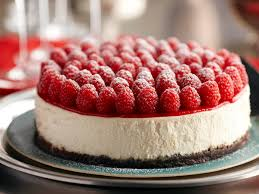

In [0]:
from IPython.display import Image
Image('images.jpg')